# [COM6513] Assignment 2: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**3 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**6 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**4 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 9 May 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc
import time
# fixing random seed for reproducibility
random.seed(210116270)
np.random.seed(210116270)

import warnings

#suppress warnings like RunTime error
warnings.filterwarnings('ignore')
start1=time.time()

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_set = pd.read_csv("Assignment 2/data_topic/train.csv", header=None)
test_set = pd.read_csv("Assignment 2/data_topic/test.csv", header=None)
dev_set = pd.read_csv("Assignment 2/data_topic/dev.csv", header=None)

In [3]:
train_set_list=list(train_set.iloc[:,1])
test_set_list=list(test_set.iloc[:,1])
dev_set_list=list(dev_set.iloc[:,1])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    x_raw=x_raw.lower()
    x=[]
    start= ngram_range[0]
    end= ngram_range[1]
    split_text=re.findall(token_pattern,x_raw)  # finds all words and number and combination and excludes special signs
    unigrams = [word for word in split_text if not word in stop_words]    # remove stopwords
        
    for n in range(start,end+1):  # calculate n grams
        if n==1:
            x.append(unigrams)
        if n>1:    # depending on choice of n, ngrams are created
            ngrams=[]
            n_grams= [unigrams[i:i+n] for i in range(len(unigrams)-n+1)]   # picks sequence of words
            for i in range(len(n_grams)): 
                ngrams.append(' '.join(n_grams[i])) # joins into a sentence e.g. ['natural','language'] to ['natural language']
            x.append(ngrams)   # add to main list with all ngrams
    x = [item for sub_list in x for item in sub_list]    # unlist items and make a single list   
    
    if len(vocab)>0: # only returns ngrmas which are present in vocab
        x= [word for word in x if word in vocab]
    return x
#(extract_ngrams(train_set_list[0], stop_words=stop_words, token_pattern= r'\b[A-Za-z][A-Za-z]+\b', vocab=vocabulary))

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
              min_df=0, keep_topN=0, 
              stop_words=[]):
    df=dict()
    ngram_counts=dict()
    for i in range(len(X_raw)):
        ngrams_list = extract_ngrams(X_raw[i], ngram_range=ngram_range, stop_words=stop_words, token_pattern=token_pattern)
        
        # seperate all elements by "," so that we get individual elements to be Counted
        ngram_freq_dict= dict(Counter(word for ngram in ngrams_list for word in ngram.split(",")))
        
        for word in ngram_freq_dict.keys():    # calculate ngram counts
            if word not in ngram_counts: ngram_counts[word]=ngram_freq_dict[word]
            else: ngram_counts[word]+=ngram_freq_dict[word]
            
        for word in set(ngrams_list):  # calculate document frequency of words
            if word in df: df[word]+=1
            else: df[word]=1
            
    for word in list(df.keys()):  # delete words which dont occur often in corpus
        if df[word]<min_df:
            del df[word]
            
    if keep_topN>0 and keep_topN<len(df.keys()): # if keep top N grams is required
        sorted_df_dict=dict(sorted(df.items(), key=lambda item: item[1], reverse=True))
        words_to_remove= list(sorted_df_dict)[keep_topN:]
        for w in words_to_remove: del df[w]

    # to remove words not in df but in ngram_counts
    extra_words = [word for word in ngram_counts if not word in df.keys()] 
    for word in extra_words: del ngram_counts[word]
    
    vocab=sorted(list(ngram_counts.keys())) # we make our vocab sorted in alphabetical order
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
# We consider all terms in the corpus
vocabulary, doc_freq, ngram_counts = get_vocab(train_set_list, min_df=0, stop_words=stop_words)
print(len(vocabulary))

8931


Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [8]:
id2word=enumerate(vocabulary)
id_word_dict=dict(id2word)
word2id=dict((word,ID) for ID,word in id_word_dict.items())

In [9]:
word2id['reuters']

6632

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [10]:
train_ngram_doc=[None]*len(train_set_list) # Creating an empty list to store extracted ngrams
for i in range(len(train_set_list)): 
    train_ngram_doc[i]=extract_ngrams(train_set_list[i], stop_words=stop_words, vocab=vocabulary)
    
test_ngram_doc=[None]*len(test_set_list) 
for i in range(len(test_set_list)): 
    test_ngram_doc[i]=extract_ngrams(test_set_list[i], stop_words=stop_words, vocab=vocabulary)

dev_ngram_doc=[None]*len(dev_set_list) 
for i in range(len(dev_set_list)): 
    dev_ngram_doc[i]=extract_ngrams(dev_set_list[i], stop_words=stop_words, vocab=vocabulary)

Then convert them into lists of indices in the vocabulary:

In [11]:
def convert_to_indices(ngram_doc):
    vocab_index_doc=ngram_doc.copy()
    for i in range(len(ngram_doc)):
        index_doc=[]
        doc=ngram_doc[i]
        for w in doc:
            index_doc.append(word2id[w])
        vocab_index_doc[i]=np.array(index_doc).T
    return (vocab_index_doc)

In [12]:
train_index_doc= convert_to_indices(train_ngram_doc)
test_index_doc= convert_to_indices(test_ngram_doc)
dev_index_doc= convert_to_indices(dev_ngram_doc)

Put the labels `Y` for train, dev and test sets into arrays: 

### **One-hot encoding labels**
We convert the labels from integers to one-hot encoded arrays. This is necessary because we need to ensure that the model finds no correlation between the labels. Eg: average of label 1 and 3 equals label 2.

Although our target variable is already label encoded, we prefer one hot encoding because our data is nominal, meaning all labels have equal significance.

If our targets were ordinal data, we could have stuck to integers.

Hence we convert labels

1 to [1,0,0],

2 to [0,1,0],

3 to [0,0,1]

This also helps us when we calculate categorical cross entropy.

In [13]:
labels_train=np.array(train_set.iloc[:,0])
labels_test=np.array(test_set.iloc[:,0])
labels_dev=np.array(dev_set.iloc[:,0])

def one_hot_encode(labels_list):
    Y_new = [None]*len(labels_list)
    for i in range(len(labels_list)):
        Y_vec=[0,0,0]
        y=int(labels_list[i])
        Y_vec[y-1]=1
        Y_new[i]=(np.asarray(Y_vec).reshape(1,3))
    return np.asarray(Y_new)

Y_train=one_hot_encode(labels_train)
Y_dev=one_hot_encode(labels_dev)
Y_test=one_hot_encode(labels_test)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [14]:
np.random.seed(210116270)
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.4): # initial values between -0.4 and 0.4
    
    W={}
    W[0] = np.random.uniform(-init_val,init_val,size=(vocab_size,embedding_dim))  # weights for embedding layer
    N=len(hidden_dim)
    for i in range(N): # weights for hidden layers
        W[i+1]= np.random.uniform(-init_val,init_val,size=(W[i].shape[1],hidden_dim[i]))
    W[N+1]= np.random.uniform(-init_val,init_val,size=(W[N].shape[1],num_classes))   # final weights
    return W
    

In [15]:
W = network_weights(vocab_size=30,embedding_dim=14,hidden_dim=[9,7,4], num_classes=2)
for i in range(len(W)):
    print(W[i].shape)

(30, 14)
(14, 9)
(9, 7)
(7, 4)
(4, 2)


Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [16]:
# np.exp(z) is not stable, because it contains infitiny. Hence we scale down the values and still preserve the order
def softmax(z):
    k = np.exp(z - np.max(z))
    sig = k / k.sum()
    return sig

def softmax_2(z):
    k= np.exp(z)
    sig= k/np.sum(k)
    return sig

In [17]:
# We can see there's no difference between proper softmax(named softmax_2) and stable softmax for small values
vec=[4,1,-2]
print("For smaller values and z =",vec)
print("Stable softmax -",softmax(vec))
print("Normal softmax -",softmax_2(vec))
print("================================")
# But for larger values, normal softmax produces Nan(not a number)
vec2=[-100,900,550]
print("For larger values and z =",vec2)
print("Stable softmax -",softmax(vec2))
print("Normal softmax -",softmax_2(vec2))

For smaller values and z = [4, 1, -2]
Stable softmax - [0.95033021 0.04731416 0.00235563]
Normal softmax - [0.95033021 0.04731416 0.00235563]
For larger values and z = [-100, 900, 550]
Stable softmax - [0.0000000e+000 1.0000000e+000 9.9295904e-153]
Normal softmax - [ 0. nan  0.]


Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [18]:
def categorical_loss(y, y_preds):
    y=y.reshape(-1,1)
    y_preds=y_preds.reshape(-1,1)
    loss=0
    for i in range(len(y)):
        loss+= - y[i] * np.log(y_preds[i])
    return loss

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [19]:
def relu(z):
    val=np.maximum(0,z)
    return val

def relu_derivative(z):
    if type(z)!= list:
        z=z.T
    dz=[]
    for value in z:
        dz.append(0) if value<=0 else dz.append(1)
    return dz


During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [20]:
def dropout_mask(size, dropout_rate):
    vec=np.ones(shape=size)
    k= int(size * dropout_rate)
    vec[:k]=0
    p = np.random.permutation(len(vec))
    d_vec = vec[p]
    dropout_vec = d_vec.reshape(1,-1)
    return dropout_vec  

In [21]:
print(dropout_mask(10, 0.2))

[[0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [22]:
def forward_pass(x, W, dropout_rate=0.2):
    val=0
    a_vecs, h_vecs, dropout_vecs=[],[],[]
    
    for index in x: val+= W[0][index]     # summation of all weights for taking average next
    h1= (1/len(x))*val        # embedding layer
    a1= relu(h1).reshape(1,-1)       #activation
    d1= dropout_mask(a1.shape[1],dropout_rate)
    a1= np.multiply(a1,d1)         # apply dropout
    dropout_vecs.append(d1)
    a_vecs.append(a1)
    h_vecs.append(h1)
    k= len(W)
    for i in range(k-2):
        h_i= np.dot(a_vecs[i],W[i+1])
        a_i= relu(h_i).reshape(1,-1)
        d_i= dropout_mask(a_i.shape[1],dropout_rate)
        a_i= np.multiply(a_i,d_i)
        
        a_vecs.append(a_i)
        h_vecs.append(h_i)
        dropout_vecs.append(d_i)
    # Representation if no hidden layer is present
    #h2=np.dot(a1,W[1])
    #a2=relu(h2).reshape(1,-1) #relu(h2).reshape(1,-1)
    #d2= dropout_mask(a2.shape[1],dropout_rate)
    #a2= np.multiply(a2,d2)
    h_l= np.dot(a_vecs[-1],W[k-1])    # h last, or output layer
    a_l= softmax(h_l).reshape(1,-1)   # last layer after softmax activation
    h_vecs.append(h_l)
    a_vecs.append(a_l)
    out_vals = {}
    
    # For 1 hidden layer
    #h_vecs = [h1,h2,h3]
    #a_vecs = [a1,a2,a3]
    #dropout_vecs = [d1,d2]
    out_vals['h']= h_vecs
    out_vals['a']= a_vecs
    out_vals['d']= dropout_vecs 
    out_vals['y']= np.argmax(a_l)+1
    
    return out_vals
    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [23]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    h_vecs=out_vals['h']
    a_vecs=out_vals['a']
    d_vecs=out_vals['d']
    k= len(W)
    dh_list, dw_list=[],[]  # dw list contains weight update for weights
    dh_last=a_vecs[k-1]-y  #error
    da_last=np.multiply(a_vecs[k-2],d_vecs[k-2])  # derevative of dropout
    dw_last=np.dot(da_last.T,dh_last)       # last set of weights
    
    dw_list.append(dw_last)
    dh_list.append(dh_last)

    for i in range(k-2): # first and last layer updated differently, so we remove 2 from k
        dh_i=np.multiply( np.dot(dh_list[-1] , W[k-1-i].T), 
                         relu_derivative(h_vecs[k-2-i]))
        da_i=np.multiply(a_vecs[k-3-i],d_vecs[k-3-i])
        dw_i=np.multiply(da_i.T , dh_i)
        dh_list.append(dh_i)
        dw_list.append(dw_i)
        
    dh1=np.multiply(np.dot(dh_list[-1],W[1].T), relu_derivative(h_vecs[0])) # embedding layer derevative
    
    #weights update
    if freeze_emb==False: # only for embedding layer
        for i in x:  # update weights in index of indices
            W[0][i]= W[0][i] - lr*dh1
            
    for i in range(k-1): # k-1 because W[0] is already updated
        # -1-i because we appended the dw's in reverse order. dw for last weights was appended first
        W[i+1]-=lr*dw_list[-1-i]  
    
    return W


# General representation if only 1 extra hidden layer present i.e., W1,W2 and W3
##    h_vecs=out_vals['h']
##    a_vecs=out_vals['a']
##    d_vecs=out_vals['d']
##    dh3=a_vecs[2]-y #  a3-y
##    da3=np.multiply(a_vecs[1],d_vecs[1])
##    dw3=np.dot(da3.T,dh3)
##    dh2=np.multiply(np.dot(dh3,W[2].T), relu_derivative(h_vecs[1]))
##    da2=np.multiply(a_vecs[0],d_vecs[0])
##    dw2=np.dot(da2.T,dh2)
##    dh1=np.multiply(np.dot(dh2,W[1].T), relu_derivative(h_vecs[0]))
##    W[0]-= lr*dw1*dh1
##    W[1]-= lr*dw2
##    W[2]-= lr*dw3
##    return W_new

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [24]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=10, tolerance=1e-04, freeze_emb=False, 
        print_progress=False, plot_fig=False):
    
    training_loss_history,validation_loss_history=[],[]
    f1_scores_train,f1_scores_val=[],[]
    for epoch_num in range(epochs):
        combined=list(zip(X_tr,Y_tr)) # To shuffle both datasets in a same way
        np.random.shuffle(combined)
        X,Y= zip(*combined) # X and Y are new randomised dataset
        
        running_loss=0                      # calculate training loss
        t1,t2,t3=0,0,0                      # to compute time taken
        
        for i in range(len(Y)):                 # we update weight for every datapoint
            X_row= X[i]                       # select row
            t1+=time.time()
            vals=forward_pass(X_row, W, dropout)
            t2+=time.time()
            y_pred=vals['a'][-1]
            W=backward_pass(X_row,Y[i],W,vals,lr=lr, freeze_emb=freeze_emb)
            t3+=time.time()
            running_loss+= (categorical_loss(Y[i],y_pred))
            
        dev_loss= np.mean([ (categorical_loss(y,(forward_pass(x, W, dropout_rate=0.0)['a'][-1]))) 
            for x,y in zip(X_dev,Y_dev)])
        training_loss_history.append(running_loss/len(X))
        validation_loss_history.append(dev_loss)
        
        preds_tr = [(forward_pass(x, W, dropout_rate=0.0)['y']) 
                        for x,y in zip(train_index_doc,labels_train)]
        f1_scores_train.append(f1_score(labels_train,preds_tr,average='macro'))
        
        preds_de = [(forward_pass(x, W, dropout_rate=0.0)['y']) 
                         for x,y in zip(dev_index_doc,labels_dev)]
        f1_scores_val.append(f1_score(labels_dev,preds_de,average='macro'))
        if print_progress : 
            print("""Epoch {} | Training loss: {:.3f} | Validation loss: {:.3f} | Train F1 score: {:.2f} |
            Val F1 score: {:.2f} | Forward pass time:{:.3f}s | Backwardward pass time:{:.3f}s |
            Total time for epoch:{:.3f}s"""
                  .format(epoch_num+1 , training_loss_history[epoch_num][0] , 
                          validation_loss_history[epoch_num],f1_scores_train[-1],
                          f1_scores_val[-1], t2-t1, t3-t2, t3-t1))
            
        if epoch_num>1 and (abs(validation_loss_history[epoch_num-1]-validation_loss_history[epoch_num])
                            <tolerance):
            if print_progress : 
                print("-------------------------------------------------------")
                print("Training stop after {} epochs as tolerance reached".format(epoch_num+1))
            break
            
    if plot_fig:
        plot_graphs(training_loss_history,validation_loss_history,f1_scores_train,f1_scores_val)
        
    return W, training_loss_history, validation_loss_history

def plot_graphs(train_losses,val_losses,train_f1,val_f1):
    fig1 = plt.figure()                # Make a figure
    ax1 = fig1.add_subplot()           # Add the new axis
    epochs_range=list(range(1,len(train_losses)+1,1))
    ax1.plot(epochs_range,train_f1,'--y+', label='F1 train scores')
    ax1.plot(epochs_range,val_f1,'--g*', label='F1 val scores')
    ax1.legend(bbox_to_anchor=(1.4, 1.05)) # move legend
    plt.xlabel("Epochs")
    plt.ylabel("F1 score")
    ax2 = ax1.twinx()                  # new Y axis
    ax2.plot(epochs_range,train_losses,'r', label='training Loss')
    ax2.plot(epochs_range,val_losses,'b-', label='validation Loss')
    plt.ylabel("Categorical Loss")
    plt.legend(bbox_to_anchor=(1.4, 0.15))
    plt.title("Loss and F1 score after each epoch")
    plt.show()

end1=time.time()

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [25]:
lr_options=np.logspace(start=-3,stop=-2,num=3)
dropout_opts=np.linspace(start=0.3,stop=0.5,num=3)
dim_opts=[50,150,300,500]
# A matrix to store info for each option
scores_matrix1= np.empty(shape=(len(lr_options)*len(dropout_opts)*len(dim_opts), 5)) 
index=0 # index for above matrix
for i in lr_options:
    for j in dropout_opts:
        for k in dim_opts:
            W1_init = network_weights(vocab_size=len(vocabulary),embedding_dim=k,
                    hidden_dim=[], num_classes=3)
            w, tl, dl = SGD(train_index_doc, Y_train, W1_init,
                            X_dev=dev_index_doc, 
                            Y_dev=Y_dev,
                            lr=i, dropout=j,
                            freeze_emb=False,
                            tolerance=1e-04,
                            epochs=10)
            preds_de = [(forward_pass(x, w, dropout_rate=0.0)['y']) 
                for x,y in zip(dev_index_doc,labels_dev)]
            f1_measure= f1_score(labels_dev,preds_de,average='macro')
            scores_matrix1[index,:]= dl[-1], f1_measure, i, j, k   # loss in last epoch, f1 score, lr, dropout, dimension
            index+= 1
best_params=scores_matrix1[np.argmin(scores_matrix1,axis=0)[0]]    # lowest Cross Entropy loss after 10 epochs
lowest_CE_loss = best_params[0]                                     # loss value
best_lr1= best_params[2]                                    #best learning rate
best_dropout1= best_params[3]                               #best dropout rate
best_dim1= best_params[4]                                   #best embedding dimension

print('The best parameters for Dev Loss {:.3f} computed over validation data is, lr={:.4f}, dropout={}, embd_dim={}'
      .format(lowest_CE_loss,(best_lr1),best_dropout1,best_dim1))
pd.DataFrame(scores_matrix1, columns = ['Dev Loss','F1 score', 'Learning Rate', 'Dropout Rate','Dimension'])

The best parameters for Dev Loss 0.244 computed over validation data is, lr=0.0100, dropout=0.4, embd_dim=500.0


,Dev Loss,F1 score,Learning Rate,Dropout Rate,Dimension
0,1.040169,0.535594,0.001000,0.3,50.0
1,0.945851,0.719854,0.001000,0.3,150.0
2,0.835579,0.791490,0.001000,0.3,300.0
3,0.741842,0.806853,0.001000,0.3,500.0
4,1.021475,0.456891,0.001000,0.4,50.0
5,0.933887,0.699621,0.001000,0.4,150.0
6,0.836870,0.745719,0.001000,0.4,300.0
7,0.730556,0.846531,0.001000,0.4,500.0
8,1.038539,0.582306,0.001000,0.5,50.0
9,0.940053,0.725405,0.001000,0.5,150.0


Shape W0 (8931, 500)
Shape W1 (500, 3)
Epoch 1 | Training loss: 0.920 | Validation loss: 0.700 | Train F1 score: 0.88 |
            Val F1 score: 0.87 | Forward pass time:0.511s | Backwardward pass time:1.442s |
            Total time for epoch:1.953s
Epoch 2 | Training loss: 0.635 | Validation loss: 0.492 | Train F1 score: 0.92 |
            Val F1 score: 0.88 | Forward pass time:0.473s | Backwardward pass time:1.258s |
            Total time for epoch:1.731s
Epoch 3 | Training loss: 0.467 | Validation loss: 0.384 | Train F1 score: 0.93 |
            Val F1 score: 0.89 | Forward pass time:0.460s | Backwardward pass time:1.368s |
            Total time for epoch:1.828s
Epoch 4 | Training loss: 0.364 | Validation loss: 0.333 | Train F1 score: 0.95 |
            Val F1 score: 0.90 | Forward pass time:0.447s | Backwardward pass time:1.382s |
            Total time for epoch:1.830s
Epoch 5 | Training loss: 0.295 | Validation loss: 0.295 | Train F1 score: 0.96 |
            Val F1 score: 0.

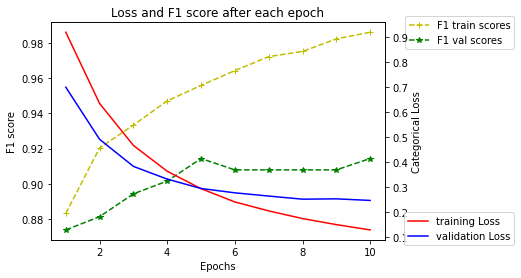

In [26]:
W1_init = network_weights(vocab_size=len(vocabulary),embedding_dim=int(best_dim1),
                    hidden_dim=[], num_classes=3)
for i in range(len(W1_init)):
    print('Shape W'+str(i), W1_init[i].shape)

W1, loss_tr1, dev_loss1 = SGD(train_index_doc, Y_train,
                            W1_init,
                            X_dev=dev_index_doc, 
                            Y_dev=Y_dev,
                            lr=best_lr1, 
                            dropout=best_dropout1,
                            freeze_emb=False,
                            tolerance=1e-04,
                            print_progress=True,
                            epochs=10,
                            plot_fig=True)


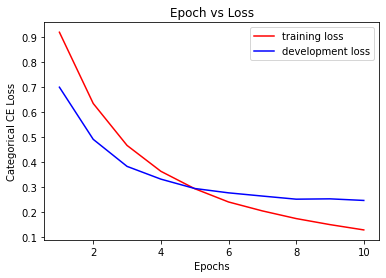

In [27]:
def plot_graph(train_losses,dev_losses):
    epochs_list=list(range(1,len(train_losses)+1,1))
    plt.plot(epochs_list, train_losses,'r-', label='training loss')
    plt.plot(epochs_list, dev_losses,'b', label='development loss')
    plt.xlabel("Epochs")
    plt.ylabel("Categorical CE Loss") 
    plt.title("Epoch vs Loss")
    plt.legend()
    plt.show()

plot_graph(loss_tr1,dev_loss1)

As per the plot of training and develpoment losses history above, it can be noted that the loss after 10 epochs for trainset is a lot lower than devset. Because the loss for training set is lower than that of losses of developement set, we say that the model is overfitting as the learned parameters are favouring training data. If the development loss was nearly equal to training loss, the model would have been a good fit. Also, the accuracy score of the model on train data is 99% while on development data, its around 91%, so we can say that the model is overfitting.

In [28]:
def compute_scores(X_test,y_test,W):
    preds_te = [(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_test,y_test)]
    a=accuracy_score(labels_test,preds_te)*100
    p=precision_score(labels_test,preds_te,average='macro')
    r=recall_score(labels_test,preds_te,average='macro')
    f=f1_score(labels_test,preds_te,average='macro')
    return a,p,r,f

Compute accuracy, precision, recall and F1-Score:

In [29]:
preds_te = [(forward_pass(x, W1, dropout_rate=0.0)['y']) 
            for x,y in zip(test_index_doc,labels_test)]

print("Evaluation metrics for test data")
print('Accuracy:', accuracy_score(labels_test,preds_te))
print('Precision:', precision_score(labels_test,preds_te,average='macro'))
print('Recall:', recall_score(labels_test,preds_te,average='macro'))
print('F1-Score:', f1_score(labels_test,preds_te,average='macro'))
scores= np.zeros(shape=(3,4))
scores[0,:]=compute_scores(test_index_doc,labels_test,W1)

Evaluation metrics for test data
Accuracy: 0.8588888888888889
Precision: 0.8614034286106286
Recall: 0.8588888888888889
F1-Score: 0.8587680521455766


### Discuss how did you choose model hyperparameters ? 

At first, a wide range of values were chosen(1x10^-9 to 0.1) for learning rate, values from (0.1 to 0.9) for dropout rate and values in multiple of 50 for embedding dimension. Based on initial runs, the sweet spot was noted and the range of values were toned down narrowly such that the computation time remained low. The number of epochs for hyperparamter tuning was kept the same at 10 epochs.

For the above model, the selection of hyperparameters was made using the lowest binary loss in last epoch. Later the best learning rate, dropout percentage and embedding dimension were chosen from possible values and the model was again trained to print the progress, plot graphs and find the accuracy metrics.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [30]:
start2=time.time()

def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocabulary:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

w_glove = get_glove_embeddings("Assignment 2/glove.840B.300d.zip","glove.840B.300d.txt",word2id)
end2=time.time()

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [31]:
lr_options=np.logspace(start=-2.5,stop=-0.5,num=4)
dropout_opts=np.linspace(start=0.2,stop=0.5,num=4)
scores_matrix2= np.empty(shape=(len(lr_options)*len(dropout_opts), 4)) # A matrix to store info for each option
index=0 # index for above matrix
for i in lr_options:
    for j in dropout_opts:
        W2_init = network_weights(vocab_size=len(vocabulary),embedding_dim=300,
                    hidden_dim=[], num_classes=3)
        W2_init[0]=w_glove # replace the weigths of the embedding matrix with w_glove
        w, tl, dl = SGD(train_index_doc, Y_train, W2_init,
                            X_dev=dev_index_doc, 
                            Y_dev=Y_dev,
                            lr=i, dropout=j,
                            freeze_emb=True,
                            tolerance=1e-04,
                            epochs=10)
        preds_de = [(forward_pass(x, w, dropout_rate=0.0)['y']) 
            for x,y in zip(dev_index_doc,labels_dev)]
        f1_measure= f1_score(labels_dev,preds_de,average='macro')
        scores_matrix2[index,:]= dl[-1], f1_measure, i, j   # loss in last epoch, f1 score, lr, dropout
        index+= 1
        
best_params=scores_matrix2[np.argmin(scores_matrix2 ,axis=0)[0]]    # lowest Cross Entropy loss after 10 epochs
lowest_CE_loss = best_params[0]                                     #loss value
best_lr2= best_params[2]                                    #best learning rate
best_dropout2= best_params[3]                                    #best dropout rate

print('The best parameters for Dev Loss {:.3f} computed over validation data is, lr={:.4f}, dropout={}'
      .format(lowest_CE_loss,(best_lr2),best_dropout2))
pd.DataFrame(scores_matrix2, columns = ['Dev Loss','F1 score', 'Learning Rate', 'Dropout Rate'])

The best parameters for Dev Loss 0.133 computed over validation data is, lr=0.3162, dropout=0.3


,Dev Loss,F1 score,Learning Rate,Dropout Rate
0,0.384416,0.900992,0.003162,0.2
1,0.383362,0.920333,0.003162,0.3
2,0.393747,0.906539,0.003162,0.4
3,0.442116,0.880889,0.003162,0.5
4,0.211729,0.946768,0.014678,0.2
5,0.224112,0.933704,0.014678,0.3
6,0.199420,0.940241,0.014678,0.4
7,0.220169,0.933135,0.014678,0.5
8,0.171153,0.933909,0.068129,0.2
9,0.143826,0.946923,0.068129,0.3


Shape W0 (8931, 300)
Shape W1 (300, 3)
Epoch 1 | Training loss: 0.499 | Validation loss: 0.205 | Train F1 score: 0.90 |
            Val F1 score: 0.93 | Forward pass time:0.530s | Backwardward pass time:0.852s |
            Total time for epoch:1.382s
Epoch 2 | Training loss: 0.377 | Validation loss: 0.139 | Train F1 score: 0.91 |
            Val F1 score: 0.95 | Forward pass time:0.452s | Backwardward pass time:0.705s |
            Total time for epoch:1.157s
Epoch 3 | Training loss: 0.372 | Validation loss: 0.232 | Train F1 score: 0.88 |
            Val F1 score: 0.92 | Forward pass time:0.508s | Backwardward pass time:0.786s |
            Total time for epoch:1.294s
Epoch 4 | Training loss: 0.361 | Validation loss: 0.152 | Train F1 score: 0.92 |
            Val F1 score: 0.95 | Forward pass time:0.406s | Backwardward pass time:0.595s |
            Total time for epoch:1.001s
Epoch 5 | Training loss: 0.359 | Validation loss: 0.140 | Train F1 score: 0.92 |
            Val F1 score: 0.

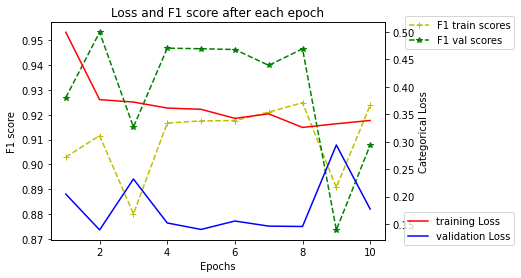

In [32]:
W2_init = network_weights(vocab_size=len(vocabulary),embedding_dim=300,
                    hidden_dim=[], num_classes=3)
W2_init[0]=w_glove
for i in range(len(W2_init)):
    print('Shape W'+str(i), W2_init[i].shape)
    
W2, loss_tr2, dev_loss2 = SGD(train_index_doc, Y_train,
                            W2_init,
                            X_dev=dev_index_doc, 
                            Y_dev=Y_dev,
                            lr=best_lr2, 
                            dropout=best_dropout2,
                            freeze_emb=True,
                            tolerance=1e-04,
                            print_progress=True,
                            epochs=10,
                            plot_fig=True)


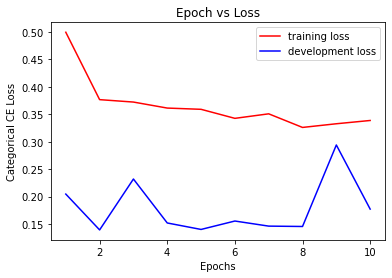

In [33]:
plot_graph(loss_tr2,dev_loss2)

As per the plot of training and develpoment losses history above, it can be noted that the loss after 10 epochs for trainset is higher than devset. This might be because the model already has pre-learnt weights, so the classification of data and accuracy on all datasets should be nearly same and might be determined by the extra set of weights between embedding layer and output layer. But the dropout layer in training phase causes many misclassifications and hence theres a high error in trainset, whereas for development set, the loss is calculated by using no dropout layer.  
If the development loss was really lower than training loss, the model would have been overfitting, but this is not the case above. Hence, we can say that the model has performed expectedly and is a good fit.

In [34]:
preds_te = [(forward_pass(x, W2, dropout_rate=0.0)['y']) 
            for x,y in zip(test_index_doc,labels_test)]
print("Evaluation metrics for test data")

print('Accuracy:', accuracy_score(labels_test,preds_te))
print('Precision:', precision_score(labels_test,preds_te,average='macro'))
print('Recall:', recall_score(labels_test,preds_te,average='macro'))
print('F1-Score:', f1_score(labels_test,preds_te,average='macro'))
scores[1,:]=compute_scores(test_index_doc,labels_test,W2)

Evaluation metrics for test data
Accuracy: 0.89
Precision: 0.8896481046542432
Recall: 0.89
F1-Score: 0.8896999375546489


### Discuss how did you choose model hyperparameters ? 

At first, a wide range of values were chosen(1x10^-9 to 0.1) for learning rate and values from (0.1 to 0.9) for dropout rate. Based on initial runs, the sweet spot was noted and the range of values were toned down narrowly such that the computation time remained low. The number of epochs for hyperparamter tuning was kept the same at 10 epochs.

For the above model, the selection of hyperparameters was made using the lowest binary loss in last epoch. Later the best learning rate and dropout percentage were chosen from possible values and the model was again trained to print the progress, plot graphs and find the accuracy metrics.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [35]:
np.random.seed(210116270)
hidden_dimensions=[130,40,9] # 3 extra hidden layers
lr_options=np.logspace(start=-2,stop=-3,num=4)
dropout_opts=np.linspace(start=0.3,stop=0.5,num=3)
scores_matrix3= np.empty(shape=(len(lr_options)*len(dropout_opts), 4)) # A matrix to store info for each option
index=0 # index for above matrix

for i in lr_options:
    for j in dropout_opts:
        W3_init = network_weights(vocab_size=len(vocabulary),embedding_dim=300,
                    hidden_dim=hidden_dimensions, num_classes=3)
        W3_init[0]=w_glove
        w, tl, dl = SGD(train_index_doc, Y_train, W3_init,
                            X_dev=dev_index_doc, 
                            Y_dev=Y_dev,
                            lr=i, dropout=j,
                            freeze_emb=True,
                            tolerance=1e-04,
                            epochs=10)
        preds_de = [(forward_pass(x, w, dropout_rate=0.0)['y']) 
            for x,y in zip(dev_index_doc,labels_dev)]
        f1_measure= f1_score(labels_dev,preds_de,average='macro')
        scores_matrix3[index,:]= dl[-1], f1_measure, i, j   # loss in last epoch, f1 score, lr, dropout
        index+= 1

best_params=scores_matrix3[np.argmin(scores_matrix3,axis=0)[0]]    # lowest Cross Entropy loss after 10 epochs
lowest_CE_loss = best_params[0]                                     #loss value
best_lr3= best_params[2]                                    #best learning rate
best_dropout3= best_params[3]                                    #best dropout rate

print('The best parameters for Dev Loss {:.3f} computed over validation data is, lr={:.4f}, dropout={}'
      .format(lowest_CE_loss,(best_lr3),best_dropout3))
pd.DataFrame(scores_matrix3, columns = ['Dev Loss','F1 score', 'Learning Rate', 'Dropout'])

The best parameters for Dev Loss 0.212 computed over validation data is, lr=0.0100, dropout=0.3


,Dev Loss,F1 score,Learning Rate,Dropout
0,0.212475,0.932660,0.010000,0.3
1,1.688669,0.541312,0.010000,0.4
2,3.647328,0.375661,0.010000,0.5
3,0.342973,0.919720,0.004642,0.3
4,0.730853,0.926342,0.004642,0.4
5,5.363662,0.490208,0.004642,0.5
6,0.309493,0.886335,0.002154,0.3
7,0.927400,0.620528,0.002154,0.4
8,1.042223,0.500186,0.002154,0.5
9,0.338832,0.854757,0.001000,0.3


Shape W0 (8931, 300)
Shape W1 (300, 130)
Shape W2 (130, 40)
Shape W3 (40, 9)
Shape W4 (9, 3)
Epoch 1 | Training loss: 0.985 | Validation loss: 0.385 | Train F1 score: 0.79 |
            Val F1 score: 0.80 | Forward pass time:1.211s | Backwardward pass time:3.114s |
            Total time for epoch:4.325s
Epoch 2 | Training loss: 0.764 | Validation loss: 1.183 | Train F1 score: 0.79 |
            Val F1 score: 0.76 | Forward pass time:1.094s | Backwardward pass time:2.907s |
            Total time for epoch:4.000s
Epoch 3 | Training loss: 0.645 | Validation loss: 0.263 | Train F1 score: 0.88 |
            Val F1 score: 0.94 | Forward pass time:1.390s | Backwardward pass time:3.599s |
            Total time for epoch:4.988s
Epoch 4 | Training loss: 0.589 | Validation loss: 2.744 | Train F1 score: 0.52 |
            Val F1 score: 0.55 | Forward pass time:1.193s | Backwardward pass time:3.120s |
            Total time for epoch:4.313s
Epoch 5 | Training loss: 0.570 | Validation loss: 0.267

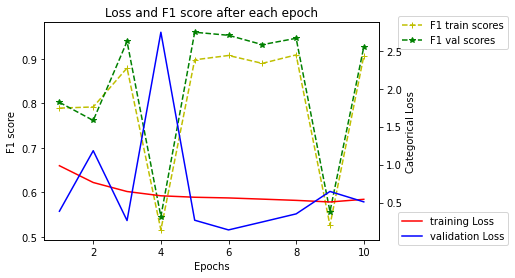

In [36]:
W3_init = network_weights(vocab_size=len(vocabulary),embedding_dim=300,
                    hidden_dim=hidden_dimensions, num_classes=3)
W3_init[0]=w_glove
for i in range(len(W3_init)):
    print('Shape W'+str(i), W3_init[i].shape)
W3, loss_tr3, dev_loss3 = SGD(train_index_doc, Y_train,
                            W3_init,
                            X_dev=dev_index_doc, 
                            Y_dev=Y_dev,
                            lr=best_lr3, 
                            dropout=best_dropout3,
                            freeze_emb=True,
                            tolerance=1e-04,
                            print_progress=True,
                            epochs=10,
                            plot_fig=True)


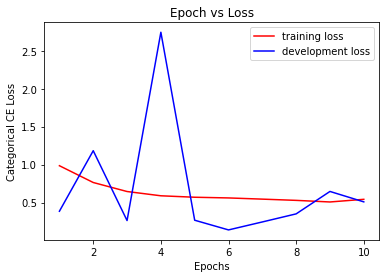

In [37]:
plot_graph(loss_tr3,dev_loss3)

As per the plot of training and develpoment losses history above, it can be noted that the loss after 10 epochs for trainset is higher than devset. But it can be noted that the difference in loss is not that high, and a look at f1 scores point out a difference of just 2% in favour of validation set, which is expected as the model has weights pre learnt and the model is just trying to find additional features between the various hidden layer and output layer. If the development loss was really lower than training loss, the model would have been overfitting. Hence, we can say that the model has performed expectedly and is a good fit.

In [38]:
preds_te = [(forward_pass(x, W3, dropout_rate=0.0)['y']) 
            for x,y in zip(test_index_doc,labels_test)]
print("Evaluation metrics for test data")

print('Accuracy:', accuracy_score(labels_test,preds_te))
print('Precision:', precision_score(labels_test,preds_te,average='macro'))
print('Recall:', recall_score(labels_test,preds_te,average='macro'))
print('F1-Score:', f1_score(labels_test,preds_te,average='macro'))
scores[2,:]=compute_scores(test_index_doc,labels_test,W3)


Evaluation metrics for test data
Accuracy: 0.9011111111111111
Precision: 0.90146087748672
Recall: 0.9011111111111111
F1-Score: 0.9001778338353109


### Discuss how did you choose model hyperparameters ? 

At first, a wide range of values were chosen(1x10^-9 to 0.1) for learning rate and values from (0.1 to 0.9) for dropout rate. Based on initial runs, the sweet spot was noted and the range of values were toned down narrowly such that the computation time remained low. The number of epochs for hyperparamter tuning was kept the same at 10 epochs.

For the above model, the selection of hyperparameters was made using the lowest binary loss in last epoch. Later the best learning rate and dropout percentage were chosen from possible values and the model was again trained to print the progress, plot graphs and find the accuracy metrics.

## Full Results

#### Add your final results here:



In [39]:
row_names=["Average Embedding","Average Embedding (Pre-trained)","Average Embedding (Pre-trained) + 3 hidden layers"]
column_names=["Accuracy %","Precision","Recall","F1-Score"]
Full_results= pd.DataFrame(scores, index=row_names, columns=column_names)
Full_results

,Accuracy %,Precision,Recall,F1-Score
Average Embedding,85.888889,0.861403,0.858889,0.858768
Average Embedding (Pre-trained),89.000000,0.889648,0.890000,0.889700
Average Embedding (Pre-trained) + 3 hidden layers,90.111111,0.901461,0.901111,0.900178


#### Please discuss why your best performing model is better than the rest.

My best performing model is the model containing pre-trained average embedding and 3 hidden layers. But the accuracy improvement over the model with just pre-trained embedding is very minute and a change of number of hidden dimension can sometimes cause the model with extra hidden layers to perform worse than the pre-trained average embedding. This is because deeper neural networks need not necessarily produce better results than shallow neural networks. In a nutshell, when a neural network is deep, it tries to reproduce the identity. This is because the first part of the neural network has established an effective set of weights for achieving the goal(pre trained average embedding), and the next parts are now just adding noise. So the last parts will try to generate an identity function, which will fail miserably because we're trying to create an identity function from a nonlinear set of activations. It is similar to approximate a line using polynomials of degree >1 and hence generating a wavy mess which does no good for predictions. 

But in above case, the hidden dimensions for deeper network were chosen after much trail and error and there was a slight increase in the accuracy compared to pre trained average embedding.

Reference- https://stats.stackexchange.com/questions/288037/more-shallow-network-outperformed-a-deeper-one-in-accuracy

In [40]:
tot_time= time.time()-start1
ex_time=end2-start2+end1-start1

In [41]:
print("Runtime of notebook excluding hyperparameter tuning is {:.2f} seconds".format(ex_time))
print("Runtime for hyperparameter tuning is {:.2f} seconds".format(tot_time-ex_time))
print("Runtime of full notebook is {:.2f} seconds".format(tot_time))

Runtime of notebook excluding hyperparameter tuning is 514.68 seconds
Runtime for hyperparameter tuning is 1509.61 seconds
Runtime of full notebook is 2024.28 seconds
